# LCPA 23-24 - "Hierarchical mergers of binary black holes"


<center><h1>Group 07</h1></center>


<center><style>
table {
    font-size: 24px;
}
</style></center>

| Last Name          | First Name            |Student Number|
|--------------------|-----------------------|----------------|
| Bertinelli         | Gabriele              |2103359         |
| Boccanera          | Eugenia               |                |
| Cacciola           | Martina               |2097476         |
| Lovato             | Matteo                |                |           


## Import modules

In [1]:
import numpy as np
import pandas as pd
import polars as pl 

import matplotlib.pyplot as plt
import hvplot
import seaborn as sns

import numpy.typing as npt
from typing import Optional, Tuple, Callable, Union, List

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.utils import resample
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

## Dataset creation

In [2]:
def create_dataset(path: str, folders: List[str], mets: List[str], cols: List[str]) -> pl.DataFrame:

    """
    Function that takes in input a list of folders and a list of metallicities.
    It returns a polars lazy DataFrame with all the data from the folders and metallicities.

    :params path: path to the data parent folder (remember to add the final '/')
    :params folders: list of selected folders
    :params mets: list of selected metallicities
    :params cols: list of selected columns original names
    :return: a `polars` DataFrame with all the data from the folders and metallicities
    """

    name = 'nth_generation.txt'

    col_name = ['c' + str(i) for i in range(28)]

    for i in range(len(folders)):
        for j in range(len(mets)):

            
            file_q = pl.scan_csv(path + folders[i] + '/Dyn/' + 
                                mets[j] + '/' + name, 
                                separator = ' ', has_header=True,
                                new_columns = col_name).select(cols) # select bold columns -> most important for this analysis
            
            
            met = pl.Series([float(mets[j]) for k in range(file_q.collect().height)]) # add metallicity column

            # univocal ID given by the original ID . metallicity folder . hosting obj folder
            new_id = pl.Series(file_q.select(pl.col('c0')).cast(pl.String).collect() + '.' + str(j) + '.' + str(i))#.cast(pl.Float64)

            # hosting object label set: 0 -> GC, 1 -> nSC, 2 -> ySC
            label = pl.Series([i for _ in range(file_q.collect().height)])

            file_q = file_q.with_columns(label.alias('label'), met.alias('met'), new_id.alias('c0')) 

            if i == 0 and j==0:
                df = file_q.collect()
                
            else:
                
                df = df.vstack(file_q.collect())

    return df


def rename_columns(df: pl.DataFrame, new_cols: List[str]) -> pl.DataFrame:
    """
    Function that takes in input a DataFrame and a list of new column names (apart from the last two columns).
    It returns a DataFrame with renamed columns.

    :params df: input `polars` or `pandas` DataFrame 
    :params new_cols: list of new column names
    :return: a `polars` or `pandas` DataFrame with renamed columns
    """
    old_cols = df.columns

    rename_dict = {old_cols[i]: new_cols[i] for i in range(len(old_cols)-2)}
    df = df.rename(rename_dict)

    return df


def get_label_ngen(df: pl.DataFrame) -> pl.DataFrame:

    """
    Function that takes in input a DataFrame and returns a new column with the label for the nth generation.
     - 0 if the ID is unique, meaning that the binary systems did not evolve further (from the 2nd generation); 
     - 1 if the ID is not unique, meaning that the binary systems evolved further (from the 2nd generation).

    :param df: DataFrame
    :return: DataFrame
    """
    id_counts = df.group_by('ID').agg(pl.count('ID').alias('count'))

    # Join the count information back to the original DataFrame
    df = df.join(id_counts, on='ID', how='left')

    # Add the new column based on your condition
    df = df.with_columns(
        pl.when(df['count'] > 1)
        .then(1)
        .otherwise(0)
        .alias('label_ngen')
    )

    # Drop the temporary count column if needed
    df = df.drop('count')

    return df

In [3]:
path = '../project/data/'

folder = ['GC_chi01_output_noclusterevolv', 'NSC_chi01_output_noclusterevolv',
               'YSC_chi01_output_noclusterevolv']
    
metallicity = ['0.0002', '0.002', '0.02', '0.0004', '0.004', '0.006', '0.0008',
                   '0.008', '0.0012', '0.012', '0.0016', '0.016']

cols = ['c0', 'c1', 'c2', 'c3', 'c4', 'c7', 'c8', 'c9', 'c13', 'c15', 'c16', 'c17', 'c25', 'c27'] # select bold columns -> most important for this analysis

new_cols = ['ID', 'bh_mass1', 'bh_mass2', 'spin1', 'spin2', 'semimajor', 'i_ecc', 'time_dyn', 'time_merge', 
'remnant_mass', 'remnant_spin', 'escape_vel', 'cluster_mass', 'n_gen']

In [4]:
df = create_dataset(path, folder, metallicity, cols)

df = rename_columns(df, new_cols)

df = get_label_ngen(df)

In [ ]:
df

In [ ]:
# %%timeit 
# df = create_dataset(path, folders=folder, mets=metallicity)

In [ ]:
# import pandas as pd
# import numpy as np

# def create_dataset_pd(path: str, folders: List[str], mets: List[str]) -> pd.DataFrame:
#     """
#     Function that takes in input a list of folders and a list of metallicities.
#     It returns a pandas DataFrame with all the data from the folders and metallicities.

#     :params path: path to the data parent folder (remember to add the final '/')
#     :params folders: list of folders
#     :params mets: list of metallicities
#     :return: a `pandas` DataFrame with all the data from the folders and metallicities
#     """

#     name = 'nth_generation.txt'
#     col_name = ['c' + str(i) for i in range(28)]
#     df = pd.DataFrame()

#     for i in range(len(folders)):
#         for j in range(len(mets)):
#             file_path = path + folders[i] + '/Dyn/' + mets[j] + '/' + name
#             file_q = pd.read_csv(file_path, sep=' ', names=col_name, header=0, low_memory=False)
#             file_q = file_q[['c0', 'c1', 'c2', 'c3', 'c4', 'c9', 'c13', 'c15', 'c16', 'c17', 'c25', 'c27']] # select bold columns -> most important for this analysis
            
#             met = pd.Series([float(mets[j]) for _ in range(file_q.shape[0])]) # add metallicity column
#             file_q['met'] = met

#             # labels set: 0 -> GC, 1 -> nSC, 2 -> ySC
#             if i == 0:
#                 label = pd.Series([0 for _ in range(file_q.shape[0])])
#             elif i == 1:
#                 label = pd.Series([1 for _ in range(file_q.shape[0])])
#             elif i == 2:
#                 label = pd.Series([2 for _ in range(file_q.shape[0])])

#             file_q['label'] = label

#             df = pd.concat([df, file_q], ignore_index=True)

#     return df

In [ ]:
# %%timeit 
# df_pd = create_dataset_pd(path, folders=folder, mets=metallicity)

In [ ]:
#df_n = df.select('c3', 'c4', 'label').sample(n=500, shuffle=True)

In [ ]:
# df_n.plot.scatter(x='c3', y='c4', by='label', alpha=0.8, figsize=(10, 10), muted_alpha=0.1)

### Data prep

In [15]:
def data_preprocessing(df: pl.DataFrame, n_sample: int, label: str, test_size: float, random_state: int=42) -> Tuple[pd.DataFrame, pd.DataFrame, npt.NDArray, npt.NDArray, npt.NDArray, npt.NDArray]:
    
    """
    Function that takes in input a `polars` DataFrame and returns the preprocessed data for the ML model.

    :params df: input `polars` DataFrame, that will be converted into a `pandas` DataFrame
    :params n_samples: number of samples to select
    :params label: label column name
    :params random_state: random state for reproducibility
    :params test_size: test size for the train/test split
    :return: a tuple with the preprocessed data: X, y, X_train, y_train, X_test, y_test
    
    """

    df =  df.to_pandas()
    
    # Separate majority and minority classes
    df_majority = df[df[label]==df[label].value_counts().idxmax()]
    df_minority = df[df[label]==df[label].value_counts().idxmin()]

    # Downsample majority class
    df_majority_downsampled = resample(df_majority, 
                                    replace=False,    # sample without replacement
                                    n_samples=df_minority.shape[0],     # to match minority class
                                    random_state=random_state) # reproducible results

    # Combine minority class with downsampled majority class
    df_balanced = pd.concat([df_majority_downsampled, df_minority])

    # Display new class counts
    print(df_balanced[label].value_counts())

    # Now let's select 10000 samples
    df_sample = df_balanced.sample(n=n_sample, random_state=random_state)

    # Define features and target
    X = df_sample.drop(['ID', 'label', 'n_gen', 'label_ngen'], axis=1)
    y = df_sample[label]

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Initialize the scaler
    scaler = MinMaxScaler()

    # Fit the scaler to the training data and transform
    X_train = scaler.fit_transform(X_train)

    # Transform the test data
    X_test = scaler.transform(X_test)

    return X, y, X_train, y_train, X_test, y_test

### Simple Random Forest

In [6]:
def simple_RF(X_train: npt.NDArray, y_train: npt.NDArray, X_test: npt.NDArray, random_state: int=42) -> Tuple[RandomForestClassifier, npt.NDArray]:
    
    """
    Function that takes in input the preprocessed data and returns a simple Random Forest model.

    :params X_train: training features
    :params y_train: training target
    :params X_test: testing features
    :params random_state: random state for reproducibility
    :return: a tuple with the model, the predictions target: model, y_pred
    
    """

    # Initialize the Random Forest Classifier
    RF = RandomForestClassifier(n_estimators=10, class_weight='balanced_subsample', criterion='entropy', random_state=random_state)

    # Fit the model to the training data
    RF.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = RF.predict(X_test)

    return RF, y_pred

def model_evaluation(model: RandomForestClassifier, X: npt.NDArray, y: npt.NDArray, X_train: npt.NDArray, y_train: npt.NDArray, X_test: npt.NDArray, y_test: npt.NDArray, y_pred: npt.NDArray) -> None:
    
    """
    Function that takes in input the model and the preprocessed data and returns the evaluation of the model: Training Score, Test Score, Confusion Matrix and Feature Importances.

    :params model: Random Forest model
    :params X: features
    :params y: target
    :params X_train: training features
    :params y_train: training target
    :params X_test: testing features
    :params y_test: testing target
    :params y_pred: model predictions
    :return: None 
    """

    #std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)

    # Get feature importances
    importances = model.feature_importances_

    # Convert the importances into one-dimensional 1darray with corresponding df column names as axis labels
    f_importances = pd.Series(importances, X.columns)

    # Sort the array in descending order of the importances
    f_importances.sort_values(ascending=False, inplace=True)

    print("Training Score:", model.score(X_train, y_train))
    print("Test score (Accuracy):    ", model.score(X_test, y_test))
    print()

    # Plot the confusion matrix
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap=plt.cm.Greys, normalize='true', text_kw={'fontsize': 11})
    plt.title('Confusion Matrix')
    plt.show()

    # Make the bar Plot from f_importances 
    f_importances.plot(x='Features', y='Importance', kind='bar', figsize=(12, 4), rot=45, fontsize=11)#, yerr=std)

### Grid Search CV

In [ ]:
# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 300, 500, 800],
    'max_depth': [5, 15, 25, 50],
    'min_samples_split': [5, 10, 15, 20, 30, 40 , 50, 60, 70, 80]
}

def gridsearch_RF(param_grid: dict, cv: int, X_train: npt.NDArray, y_train: npt.NDArray, X_test: npt.NDArray, n_jobs: int, random_state: int=42, verbose: int=2) -> Tuple[RandomForestClassifier, npt.NDArray, dict]:
    
    """
    Function that takes in input the parameter grid and the preprocessed data and returns the best model and the predictions.

    :params param_grid: parameter grid for the Grid Search
    :params cv: cross-validation folds
    :params X_train: training features
    :params y_train: training target
    :params X_test: testing features
    :params random_state: random state for reproducibility
    :params verbose: verbosity level
    :params n_jobs: number of jobs to run in parallel
    :return: a tuple with the best model and the predictions: model, y_pred
    
    """

    RF = RandomForestClassifier(criterion='entropy', class_weight='balanced_subsample', random_state=random_state)

    # Initialize the grid search model
    grid_search = GridSearchCV(estimator=RF, param_grid=param_grid, cv=cv, verbose=verbose, n_jobs=n_jobs, return_train_score=True)

    # Fit the grid search to the data
    grid_search.fit(X_train, y_train)

    # Get the best parameters
    best_params = grid_search.best_params_
    best_index = grid_search.best_index_

    print('Best parameters:', best_params)
    print('ID of the best combination:', best_index)

    # Fit the model with the best parameters
    RF_best = RandomForestClassifier(**best_params)
    RF_best.fit(X_train, y_train)

    # Predict on the test set
    y_pred = RF_best.predict(X_test)

    return RF_best, y_pred, grid_search

label_ngen
0    11683
1    11683
Name: count, dtype: int64
Training Score: 0.9885
Test score (Accuracy):     0.85



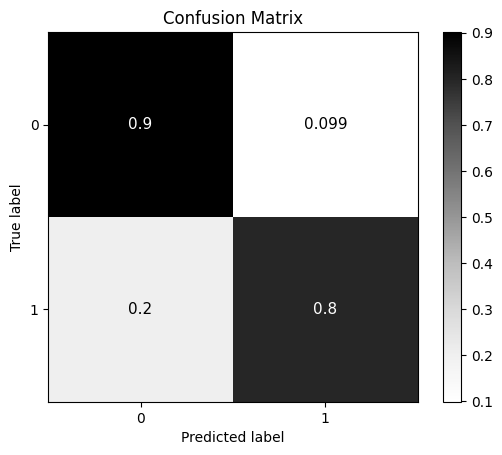

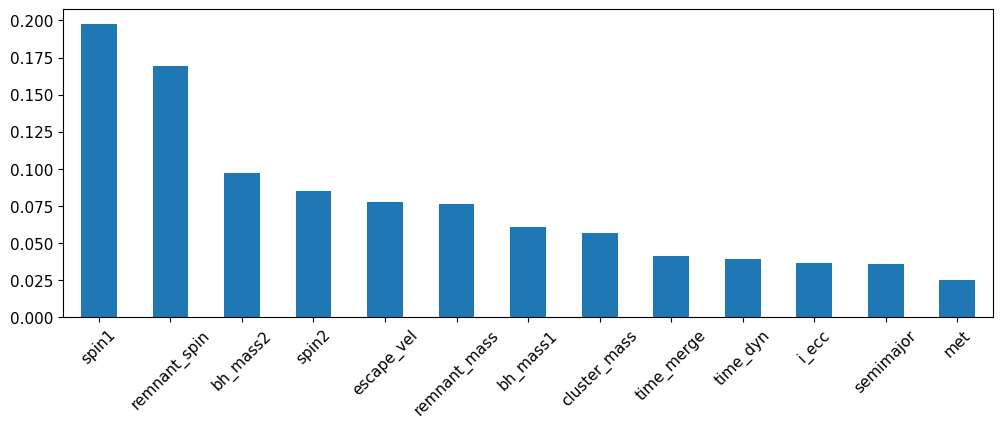

In [16]:
df_1 = df.filter(pl.col('label')==0)
X, y, X_train, y_train, X_test, y_test = data_preprocessing(df_1, n_sample=5000, label='label_ngen', test_size=0.2)


RF, y_pred = simple_RF(X_train, y_train, X_test)

model_evaluation(RF, X, y, X_train, y_train, X_test, y_test, y_pred)

In [ ]:
%%time
X, y, X_train, y_train, X_test, y_test = data_preprocessing(df, n_samples=10000, label='label', random_state=42, test_size=0.2)


RF_best, y_pred, grid_search = gridsearch_RF(param_grid=param_grid, cv=3, X_train=X_train, y_train=y_train, X_test=X_test, n_jobs=25)

model_evaluation(RF_best, X, y, X_train, y_train, X_test, y_test, y_pred)

In [ ]:
def model_scores(grid_search: dict, best_index: int) -> None:

    """
    Function that takes in input the grid search results and the best index and returns the mean test scores plot.

    :params grid_search: grid search results
    :params best_index: best index
    :return: None
    """
    # Get mean test scores
    mean_test_scores = grid_search.cv_results_['mean_test_score']
    mean_train_scores = grid_search.cv_results_['mean_train_score']

    # Plot mean test scores
    plt.figure(figsize=(10, 6))

    plt.plot(range(1, len(mean_test_scores)+1), mean_test_scores, label='Mean Test Score', color='blue')
    plt.plot(range(1, len(mean_train_scores)+1), mean_train_scores, label='Mean Train Score', color='orange')
    plt.xlabel('Index of hyperparameter combination')
    plt.vlines(x=best_index, ymin=0, ymax=1.2, color='green', label='Best combination')
    plt.ylabel('Mean Score')
    plt.legend(loc='best')
    plt.ylim(0.5, 1.1)
    plt.show()

In [ ]:
model_scores(grid_search, best_index=55)

In [ ]:
import shap

# Create object that can calculate shap values
explainer = shap.TreeExplainer(rf)

# Calculate Shap values
shap_values = explainer.shap_values(X_train[:150].values)

In [ ]:
fig = plt.figure()

ax0 = fig.add_subplot(211)
ax0.set_title('Non-evolved - 0')
shap.summary_plot(np.abs(shap_values[0]), X_test[:150], plot_type='violin', show=False)
ax0.set_xlabel('SHAP values (impact on output model)', fontsize=11)



ax1 = fig.add_subplot(212)
ax1.set_title('Evolved - 1')
shap.summary_plot(np.abs(shap_values[1]), X_test[:150], plot_type='violin', show=False)
ax1.set_xlabel('SHAP values (impact on output model)', fontsize=11)


# ax2 = fig.add_subplot(313)
# plt.title('Class 0 - CE')
# shap.summary_plot(shap_values[0], X_test[:150], plot_type='violin', show=False)
# plt.xlabel('SHAP values (impact on output model)', fontsize=11)

plt.subplots_adjust(hspace = 50)
plt.gcf().set_size_inches(7,10)
plt.tight_layout()
plt.show()

In [ ]:
import shap
shap_values = shap.TreeExplainer(rf).shap_values(X_test[:150])
shap.summary_plot(shap_values, X_test[:150])